In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import axion_motion
import clock_work_axion
import model
import transport_equation
import plot_tools
from common.rh_neutrino import calc_Gamma_a_SU2
from common.util import latex_exponential_notation, make_plot_path

In [3]:
def sim_and_plot(m_a, Gamma_phi, H_inf, filename=None, t_end=5e-5):
    m = model.AxionBaryogenesisModel(
        source_vector=transport_equation.source_vector_weak_sphaleron, 
        get_axion_source=axion_motion.get_standard_axion_source,
        axion_rhs=axion_motion.axion_rhs_simple, calc_axion_mass=axion_motion.calc_const_axion_mass, 
        axion_initial=(1, 0), axion_parameter=(m_a,), 
        Gamma_phi=Gamma_phi, H_inf=H_inf)
    r = model.solve(m, collect=True, t_end=t_end)
    plot_tools.plot(r, filename, m_a=m_a, Gamma_phi=Gamma_phi, H_inf=H_inf)
    return m, r

In [4]:
H_inf = 2e10

<ipython-input-3-0aead7bd945d>:20: RuntimeWarning: invalid value encountered in true_divide
  y = theta_dot / T / 1e-6


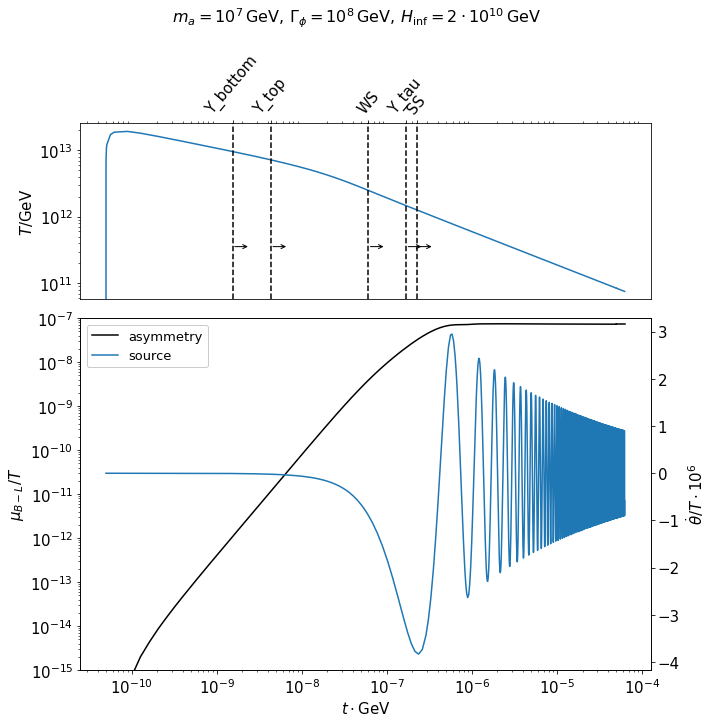

In [5]:
m, r = sim_and_plot(1e7, 1e8, H_inf, f_a) # , filename="evolution.pdf");

<ipython-input-3-0aead7bd945d>:20: RuntimeWarning: invalid value encountered in true_divide
  y = theta_dot / T / 1e-6


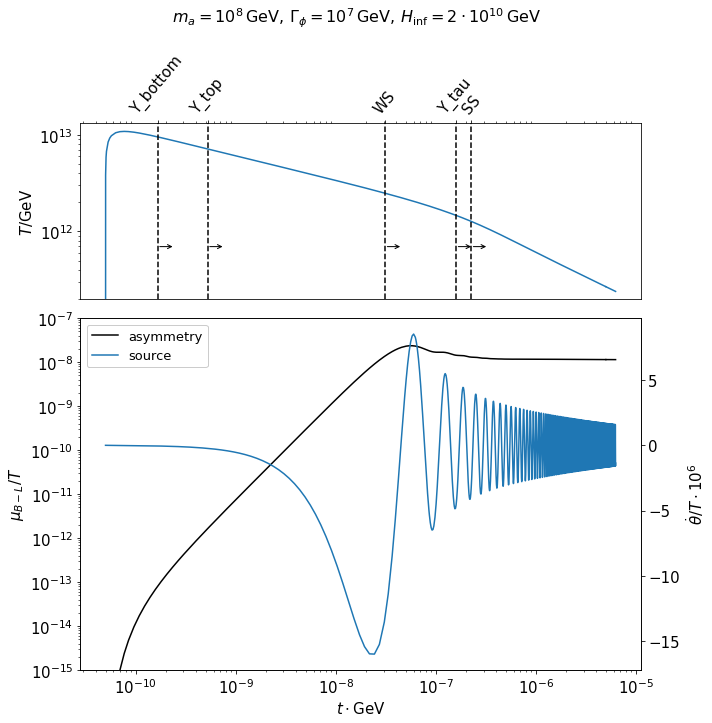

In [6]:
m2, r2 = sim_and_plot(1e8, 1e7, H_inf, f_a, t_end=5e-6)